In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tfkan.layers import DenseKAN

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
# set float64 as default
tf.keras.backend.set_floatx('float64')

In [2]:
x = np.random.uniform(low=-1, high=1, size=(1000, 2))
y = np.exp(np.sin(np.pi * x[:, 0]) + x[:, 1]**2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [4]:
def get_flatten_params(model):
    params = []
    for var in model.trainable_variables:
        params.append(tf.reshape(var, (-1)))
    return tf.concat(params, axis=0)

def set_flatten_params(model, flatten_params):
    idx = 0
    for var in model.trainable_variables:
        shape = var.shape
        param_size = tf.reduce_prod(shape)
        param_value = tf.reshape(flatten_params[idx:idx + param_size], shape)
        var.assign(param_value)
        idx += param_size

In [6]:
def train_model_lbfgs(model, x_train, y_train, x_valid, y_valid, 
                      epoches: int=1000, verbose: int=100, extend_epoch: int=300):
    def get_loss_and_grad(params):
        set_flatten_params(model, params)
        with tf.GradientTape() as tape:
            y_pred = model(x_train)
            loss = tf.reduce_mean((y_train - y_pred)**2)
        grads = tape.gradient(loss, model.trainable_variables)
        grads = tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)
        return loss, grads

    train_mse, valid_mse = [], []
    for epoch in range(epoches):
        # optimize model using L-BFGS
        epoch_results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=get_loss_and_grad,
            initial_position=get_flatten_params(model),
            tolerance=1e-12,
            max_iterations=1
        )

        # evaluate model
        if epoch == 0 or (epoch + 1) % verbose == 0:
            train_mse.append(tf.reduce_mean((y_train - model(x_train))**2).numpy())
            valid_mse.append(tf.reduce_mean((y_valid - model(x_valid))**2).numpy())
            print(f"[Epoch {(epoch + 1):4d}], Train MSE: {train_mse[-1]:.6f}, Valid MSE: {valid_mse[-1]:.6f}")
        
        # extend grid size
        if (epoch + 1) % extend_epoch == 0 and (epoch + 1) < epoches:
            samples = x_train
            for layer in model.layers:
                if hasattr(layer, 'extend_grid_from_samples'):
                    extend_gird_size = layer.grid_size * 2
                    layer.extend_grid_from_samples(samples, extend_gird_size)
                samples = layer(samples)
    
    return train_mse, valid_mse

In [7]:
# KAN
kan = tf.keras.models.Sequential([
    DenseKAN(5, grid_size=5, dtype=tf.float64),
    DenseKAN(1, grid_size=5, dtype=tf.float64)
])
kan.build(input_shape=(None, 2))
kan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_kan (DenseKAN)        (None, 5)                 119       
                                                                 
 dense_kan_1 (DenseKAN)      (None, 1)                 106       
                                                                 
Total params: 225 (1.76 KB)
Trainable params: 141 (1.10 KB)
Non-trainable params: 84 (672.00 Byte)
_________________________________________________________________


In [8]:
extend_epoch = 300
train_mse, valid_mse = train_model_lbfgs(
    kan, x_train, y_train, x_test, y_test, epoches=1800, verbose=100, extend_epoch=extend_epoch)

[Epoch    1], Train MSE: 2.087397, Valid MSE: 1.763854
[Epoch  100], Train MSE: 0.007428, Valid MSE: 0.005888
[Epoch  200], Train MSE: 0.003105, Valid MSE: 0.002621
[Epoch  300], Train MSE: 0.002839, Valid MSE: 0.002428
[Epoch  400], Train MSE: 0.000831, Valid MSE: 0.000636
[Epoch  500], Train MSE: 0.000352, Valid MSE: 0.000303
[Epoch  600], Train MSE: 0.000306, Valid MSE: 0.000270
[Epoch  700], Train MSE: 0.000121, Valid MSE: 0.000100
[Epoch  800], Train MSE: 0.000082, Valid MSE: 0.000076
[Epoch  900], Train MSE: 0.000069, Valid MSE: 0.000068
[Epoch 1000], Train MSE: 0.000045, Valid MSE: 0.000063
[Epoch 1100], Train MSE: 0.000035, Valid MSE: 0.000061
[Epoch 1200], Train MSE: 0.000028, Valid MSE: 0.000058
[Epoch 1300], Train MSE: 0.000019, Valid MSE: 0.000093
[Epoch 1400], Train MSE: 0.000015, Valid MSE: 0.000095
[Epoch 1500], Train MSE: 0.000012, Valid MSE: 0.000098
[Epoch 1600], Train MSE: 0.000007, Valid MSE: 0.001691
[Epoch 1700], Train MSE: 0.000005, Valid MSE: 0.001835
[Epoch 180

(-1.0, 19.0)

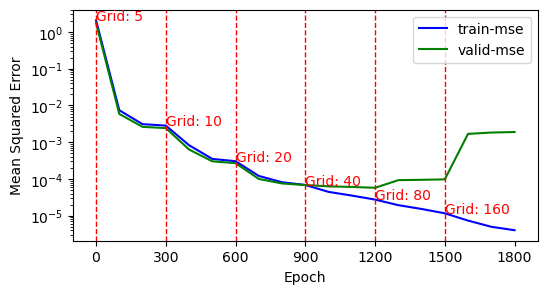

In [11]:
fig = plt.figure(figsize=(6,3))
plt.semilogy(train_mse, label='train-mse', color='blue')
plt.semilogy(valid_mse, label='valid-mse', color='green')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
grids_update = []
num_grid_start, extent_epoch, verbose = 5, 300, 100
for i in range(6):
    grids_update.append((extent_epoch * i // verbose, num_grid_start))
    num_grid_start *= 2
# plot grid size update
for epoch, grid_size in grids_update:
    plt.axvline(x=epoch, color='red', linestyle='--', linewidth=1, c='red')
    plt.text(epoch, train_mse[epoch], f"Grid: {grid_size}", color='red')
# set xticks
xticks = np.arange(0, len(train_mse), extend_epoch // verbose)
plt.xticks(xticks, [int(x) * 100 for x in xticks])
plt.xlim(-1, len(train_mse))